# Download the Data

In [1]:
# If necessary
# !pip3 install tqdm
# !pip3 install pillow

In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.image_uris import retrieve
from sagemaker.session import TrainingInput
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
def download_and_extract(data_dir, download_dir, urls):
    """
    Downloads files from a list of URLs and extracts them to a specified directory.

    Parameters:
    - data_dir (str): The directory where the extracted files will be stored.
    - download_dir (str): The directory where the files will be downloaded.

    Returns:
    None
    """

    # Check if the 'data' directory exists, if not, create it
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)

    # Iterate over each URL
    for url in urls:
        # Get the target file name from the URL
        target_file = url.split('/')[-1]

        # Check if the file is already downloaded in the download directory
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)

            # Download the file from the URL and save it to the download directory
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))

            # Open the tar file and extract its contents to the data directory
            tf = tarfile.open(os.path.join(download_dir, target_file))
            tf.extractall(data_dir)
            tf.close()

            print('Extraction complete for', target_file)
        else:
            print('Already downloaded', url)

In [4]:
if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.', urls)

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Extracting Annotations from XML Format

In [5]:
# Create a list of full paths to XML files in xml_dir, filtering out non-XML files
xml_dir = 'data/annotations/xmls/'
xml_files = [os.path.join(xml_dir, x) for x in os.listdir(xml_dir) if x[-3:] == 'xml']
# See a random XML file
xml_files[random.randint(0, len(xml_files) - 1)]

'data/annotations/xmls/Russian_Blue_186.xml'

In [6]:
classes = ['cat', 'dog']
categories = [
    {
        'class_id': 0,
        'name': 'cat'
    },
    {
        'class_id': 1,
        'name': 'dog'
    }
]

In [7]:
def extract_annotation(xml_file_path):
    """
    Extracts annotation information from an XML file representing an image annotation.

    Parameters:
    - xml_file_path (str): The path to the XML file containing the image annotation.

    Returns:
    - annotation (dict): A dictionary containing information about the image annotation.
        - 'file': The filename of the annotated image.
        - 'categories': A list of categories or classes used in the annotation.
        - 'image_size': A list containing a dictionary with image dimensions (width, height, depth).
        - 'annotations': A list of dictionaries, each representing an annotated object in the image.
            - 'class_id': The numeric identifier of the object's class.
            - 'left': The x-coordinate of the top-left corner of the bounding box.
            - 'top': The y-coordinate of the top-left corner of the bounding box.
            - 'width': The width of the bounding box.
            - 'height': The height of the bounding box.
    """
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotation = {}

    # Extract filename and categories
    annotation['file'] = root.find('filename').text
    annotation['categories'] = categories

    # Extract image size information
    size = root.find('size')
    annotation['image_size'] = [{
        'width': int(size.find('width').text),
        'height': int(size.find('height').text),
        'depth': int(size.find('depth').text)
    }]

    # Extract annotations for each object in the image
    annotation['annotations'] = []

    for item in root.iter('object'):
        class_id = classes.index(item.find('name').text)
        ymin, xmin, ymax, xmax = None, None, None, None

        for box in item.findall('bndbox'):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)

            if all([xmin, ymin, xmax, ymax]) is not None:
                annotation['annotations'].append({
                    'class_id': class_id,
                    'left': xmin,
                    'top': ymin,
                    'width': xmax - xmin,
                    'height': ymax - ymin
                })
    return annotation

In [8]:
# Looking a random annotation
extract_annotation(xml_files[random.randint(0, len(xml_files) - 1)])

{'file': 'saint_bernard_135.jpg',
 'categories': [{'class_id': 0, 'name': 'cat'},
  {'class_id': 1, 'name': 'dog'}],
 'image_size': [{'width': 500, 'height': 321, 'depth': 3}],
 'annotations': [{'class_id': 1,
   'left': 279,
   'top': 60,
   'width': 101,
   'height': 108}]}

# Visualize Data

In [9]:
def plot_example(plt, annot, image_file_path, rows, cols, index):
    """
    Plots annotated objects on an image and displays it using matplotlib.

    Parameters:
    - plt (matplotlib.pyplot): The matplotlib.pyplot module for plotting.
    - annot (dict): Annotation information containing object details.
    - image_file_path (str): The path to the image file.
    - rows (int): Number of rows in the subplot grid.
    - cols (int): Number of columns in the subplot grid.
    - index (int): The index of the subplot.

    Returns:
    - plt (matplotlib.pyplot): The matplotlib.pyplot module with the plotted image.
    """

    # Open the image file
    img = Image.open(image_file_path)

    # Create a drawing object for annotations
    draw = ImageDraw.Draw(img)

    # Load a font for text annotations
    font = ImageFont.truetype('DejaVu_Serif/DejaVuSerif-Bold.ttf', 20)

    # Iterate over annotations and draw rectangles and text on the image
    for a in annot['annotations']:
        box = [
            int(a['left']), int(a['top']),
            int(a['left']) + int(a['width']),
            int(a['top']) + int(a['height'])
        ]
        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(a['class_id'])], font=font)

    # Configure the subplot using matplotlib
    plt.subplot(rows, cols, index + 1)
    plt.xticks([])
    plt.yticks([])

    # Display the annotated image
    plt.imshow(img)

    return plt

In [10]:
def show_random_annotations(plt):
    """
    Displays a grid of randomly selected annotated images using matplotlib.

    Parameters:
    - plt (matplotlib.pyplot): The matplotlib.pyplot module for plotting.

    Returns:
    None
    """

    # Set the figure size for the entire grid of images
    plt.figure(figsize=(16, 16))

    # Iterate over a range to display 3x3 grid of randomly selected annotated images
    for i in range(0, 9):
        # Randomly select an index to retrieve an XML file path
        index = random.randint(0, len(xml_files) - 1)

        # Extract annotation information and obtain the corresponding image file path
        annot = extract_annotation(xml_files[index])
        image_file_path = os.path.join('data/images/', annot['file'])

        # Plot the annotated image in the subplot
        plt = plot_example(plt, annot, image_file_path, 3, 3, i)

    # Show the plotted grid of images
    plt.show()

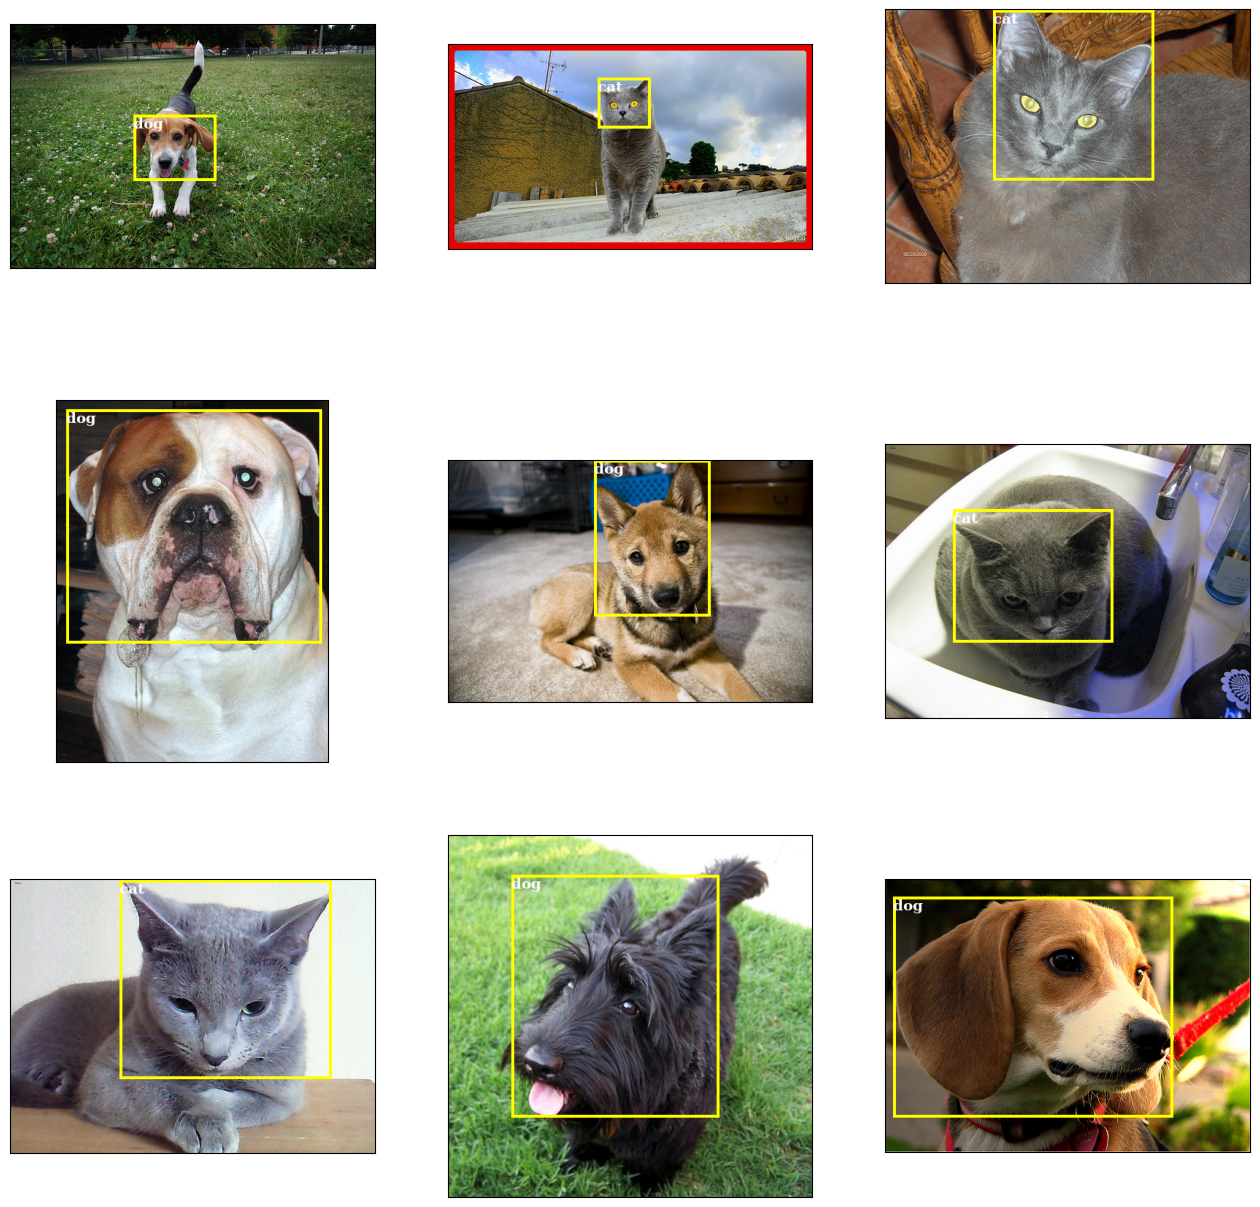

In [11]:
show_random_annotations(plt)

# SageMaker Setup

In [12]:
# Retrieve the IAM role associated with the SageMaker execution environment
role = sagemaker.get_execution_role()
# Specify the name of the Amazon S3 bucket where data will be stored
bucket_name = 'petsdata7032'

# Retrieve the image URI for the 'object-detection' algorithm in the current AWS region
training_image = retrieve('object-detection', boto3.Session().region_name)
# Display the training image URI
print(f'Training image URI: {training_image}')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Training image URI: 433757028032.dkr.ecr.us-west-2.amazonaws.com/object-detection:1


In [13]:
# Let's create some folders or delete them if exists and then create them
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [15]:
print('Total examples:', len(xml_files))

Total examples: 3686


In [16]:
# Iterate over each XML file in the list with progress bar (tqdm)
for xml_file in tqdm(xml_files):
    # Assign the target set randomly based on a 75-25 split
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    # Extract annotation information from the XML file
    annot = extract_annotation(xml_file)
    
    # Construct paths for source and target images
    image_file_path = os.path.join('data/images/', annot['file'])
    image_target_path = os.path.join(target_set, annot['file'])
    
    # Copy the image to the target set folder
    shutil.copy(image_file_path, image_target_path)
    
    # Construct the path for the JSON annotation file
    json_file_path = os.path.join(target_set + '_annotation', annot['file'][:-3] + 'json')
    
    # Write the annotation information to a JSON file
    with open(json_file_path, 'w') as f:
        json.dump(annot, f)

100%|██████████| 3686/3686 [00:10<00:00, 339.49it/s]


In [17]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [18]:
print(len(train_annots), len(train_images))

2757 2757


In [19]:
# iterates over image file names (train_images) and prints a message for each JSON file not found in (train_annots).
for image in train_images:
    key = image.split('.')[0]
    json_file = key + '.json'
    if json_file not in train_annots:
        print('Not found', json_file)

# Uploading Data to S3

In [20]:
sess = sagemaker.Session()

print('Uploading training images...')
s3_train_path = sess.upload_data(path='train', bucket='petsdata7032', 
                                 key_prefix='train')
print('Training images uploaded')

print('Uploading validation images...')
s3_validation_path = sess.upload_data(path='validation', bucket='petsdata7032', 
                                      key_prefix='validation')
print('Validation images uploaded')

print('Uploading data train_annotation...')
s3_train_annot_path = sess.upload_data(path='train_annotation', bucket='petsdata7032', 
                                       key_prefix='train_annotation')
print('train_annotation data uploaded')

print('Uploading data validation_annotation...')
s3_validation_annot_path = sess.upload_data(path='validation_annotation', bucket='petsdata7032', 
                                        key_prefix='validation_annotation')
print('validation_annotation data uploaded')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Uploading training images...
Training images uploaded
Uploading validation images...
Validation images uploaded
Uploading data train_annotation...
train_annotation data uploaded
Uploading data validation_annotation...
validation_annotation data uploaded


In [21]:
s3_train_path

's3://petsdata7032/train'

# SageMaker Estimator

In [22]:
# Create a SageMaker Estimator object for model training
model = sagemaker.estimator.Estimator(
    training_image,                          # Path to the training script or container image
    role=role,                               # SageMaker IAM role for executing training jobs
    instance_type='ml.p3.2xlarge',           # Type of EC2 instance used for training
    instance_count=1,                        # Number of instances to use for training
    volume_size=100,                         # Size (in GB) of the ML storage volume
    max_run=36000,                           # Maximum allowed runtime for training (in seconds)
    input_mode='File',                       # Mode for input data transfer
    output_path='s3://petsdata7032/output',  # S3 path where model artifacts will be stored
    sagemaker_session=sess,                  # SageMaker Session object
    base_job_name='ObjectDetection'
)

# Hyperparameters

In [23]:
# Set hyperparameters for the training job
model.set_hyperparameters(
    base_network='resnet-50',          # Base neural network architecture
    num_classes=2,                     # Number of classes in the dataset
    use_pretrained_model=1,            # Whether to use a pre-trained model
    mini_batch_size=16,                # Size of mini-batches used for training
    epochs=15,                         # Number of training epochs
    learning_rate=0.001,               # Learning rate for the optimizer
    optimizer='sgd',                   # Optimization algorithm ('sgd' for stochastic gradient descent)
    lr_scheduler_step='10',            # Learning rate scheduler step size
    lr_scheduler_factor=0.1,           # Learning rate scheduler factor
    momentum=0.9,                      # Momentum for the optimizer
    weight_decay=0.0005,               # Weight decay for the optimizer
    overlap_threshold=0.5,             # Threshold for bounding box overlap during evaluation
    nms_threshold=0.45,                # Threshold for non-maximum suppression during evaluation
    image_shape=512,                   # Input image shape (assuming square images)
    num_training_samples=len(train_annots)  # Number of training samples in the dataset
)

# Data Channels

In [24]:
# Define TrainingInput objects for training and validation data
train_data = TrainingInput(
                           s3_train_path, # S3 path for the training data 
                           distribution='FullyReplicated', # Data distribution strategy
                           content_type='application/x-image', # MIME type of the content in the input data
                           s3_data_type='S3Prefix' # Type of S3 data (e.g., 'S3Prefix' or 'ManifestFile'
                            )

validation_data = TrainingInput(
                            s3_validation_path, 
                            distribution='FullyReplicated',
                            content_type='application/x-image', 
                            s3_data_type='S3Prefix'
                            )

# Define TrainingInput objects for training and validation annotations data
train_annot_data = TrainingInput(
                                s3_train_annot_path,
                                distribution='FullyReplicated',
                                content_type='application/x-image',
                                s3_data_type='S3Prefix')

validation_annot_data = TrainingInput(
                                    s3_validation_annot_path,
                                    distribution='FullyReplicated',
                                    content_type='application/x-image',
                                    s3_data_type='S3Prefix')

In [25]:
# Create a dictionary to organize data channels for the training job
data_channels ={
    'train' : train_data,
    'validation': validation_data,
    'train_annotation': train_annot_data,
    'validation_annotation': validation_annot_data
}

In [26]:
data_channels

{'train': <sagemaker.inputs.TrainingInput at 0x7ff354e838b0>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7ff354e80640>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7ff354e82fe0>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7ff354e830a0>}

# Model Training

In [27]:
# Start the model training process using the specified data channels
model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: ObjectDetection-2023-12-11-22-56-05-349


2023-12-11 22:56:05 Starting - Starting the training job......
2023-12-11 22:56:43 Starting - Preparing the instances for training......
2023-12-11 22:57:45 Downloading - Downloading input data...
2023-12-11 22:58:25 Downloading - Downloading the training image.....................
2023-12-11 23:02:06 Training - Training image download completed. Training in progress.....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Mon Dec 11 23:02:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |   

# Deploy Model

In [28]:
deployed_model = model.deploy(
                            initial_instance_count=1, # Number of instances to deploy initially
                            instance_type='ml.m4.xlarge' # Type of EC2 instance for deployment
                            )
print('\nModel deployed!')

INFO:sagemaker:Creating model with name: ObjectDetection-2023-12-11-23-25-01-734
INFO:sagemaker:Creating endpoint-config with name ObjectDetection-2023-12-11-23-25-01-734
INFO:sagemaker:Creating endpoint with name ObjectDetection-2023-12-11-23-25-01-734


------------!
Model deployed!


# Predictions

In [29]:
image_dir = 'validation' # Directory containing validation images
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

929


In [30]:
deployed_model.content_type = 'image/jpeg'

In [31]:
index = 0

image_path = os.path.join(image_dir, images[index])

# Read the content of the image file into a bytearray
with open(image_path, 'rb') as f:
    b = bytearray(f.read())

# Send the image data to the deployed SageMaker model for prediction
results = deployed_model.predict(b)
# Parse the JSON-formatted results into a Python dictionary
results = json.loads(results)

# Extract the predictions from the dictionary
preds = results['prediction']

In [32]:
preds[random.randint(0, len(preds) - 1)]

[1.0,
 0.020276010036468506,
 0.28415095806121826,
 0.0,
 0.3805422782897949,
 0.06669193506240845]

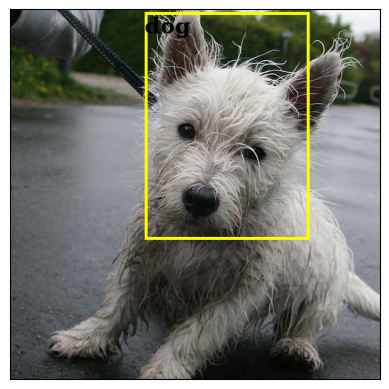

In [33]:
# Open the image using the PIL library
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('DejaVu_Serif/DejaVuSerif-Bold.ttf', 30)
w, h = img.size

# Iterate over each prediction in the 'preds' list
for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = pred
    
    if score > 0.7:
        box = [w*xmin, h*ymin, w*xmax, h*ymax]

        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(class_id)], font=font, fill='#000000')
    else:
        break

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)